In [46]:
import numpy as np
import pandas as pd

import itertools

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb, lightgbm as lgbm, catboost as catb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [5]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [6]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

In [7]:
def init_models():
    model_lr = LogisticRegression(random_state=21)
    model_knn = KNeighborsClassifier()
    model_tree = DecisionTreeClassifier(random_state=21)
    model_xgb = xgb.XGBClassifier(random_state=21)
    model_lgbm = lgbm.LGBMClassifier(random_state=21)
    model_catb = catb.CatBoostClassifier(silent=True, random_state=21)

    models = {
        'lr': model_lr,
        'knn': model_knn,
        'tree': model_tree,
        'xgb': model_xgb,
        'lgbm': model_lgbm,
        'cat': model_catb
    }
    return models

In [8]:
def get_metrics(report):
    f1_macro = report['macro avg']['f1-score']
    f1_0 = report['0']['f1-score']
    f1_1 = report['1']['f1-score']
    return f1_macro, f1_0, f1_1

In [159]:
def run_experiment(X_train, X_test, y_train, y_test, method='not'):
#     assert method in ['not', 'over', 'under', 'tomek', 'smote'], 'Неправильный метод сэмплирования'
    assert method in ['not', 
                      'over', 
                      'under', 
                      'tomek', 
                      'smote', 
                      'over_under', 
                      'tomek_smote', 
                      'tomek_over'], 'Неправильный метод сэмплирования'
    
    models = init_models()
    
    stata = pd.DataFrame()
    for name, model in models.items():
        model.fit(X_train, y_train)
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)

        report_train = classification_report(y_train, pred_train, output_dict=True)
        report_test = classification_report(y_test, pred_test, output_dict=True)
        f1_macro_train, f1_0_train, f1_1_train = get_metrics(report_train)
        f1_macro_test, f1_0_test, f1_1_test = get_metrics(report_test)

        stata = stata.append({
            'model_name': name,
            f'f1_macro_train_{method}': f1_macro_train,
            f'f1_macro_test_{method}': f1_macro_test,
            f'f1_0_train_{method}': f1_0_train,
            f'f1_0_test_{method}': f1_0_test,
            f'f1_1_train_{method}': f1_1_train,
            f'f1_1_test_{method}': f1_1_test
        }, ignore_index=True)
    return stata, models

**Пути к директориям и файлам**

In [10]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

In [11]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)

In [12]:
train_df.shape

(7500, 17)

In [13]:
test_df = pd.read_csv(TEST_DATASET_PATH)

In [14]:
test_df.shape

(2500, 16)

# ТЕКУЩИЕ ВОЗМОЖНОСТИ

#### задание имени целевой переменной

In [15]:
TARGET_NAME = 'Credit Default'

#### функции предобработки данных

In [16]:
def generate_dummies_from_home_ownership(X):
    X['G_home_ownership_home_mortgage'] = 0
    X.loc[X['Home Ownership'] == 'Home Mortgage', 'G_home_ownership_home_mortgage'] = 1
    
    X['G_home_ownership_rent'] = 0
    X.loc[X['Home Ownership'] == 'Rent', 'G_home_ownership_rent'] = 1
    
    X['G_home_ownership_own_home'] = 0
    X.loc[X['Home Ownership'] == 'Own Home', 'G_home_ownership_own_home'] = 1
    
    X['G_home_ownership_have_mortgage'] = 0
    X.loc[X['Home Ownership'] == 'Have Mortgage', 'G_home_ownership_have_mortgage'] = 1
    
    X['G_home_ownership_other'] = 0
    X.loc[~X['Home Ownership'].isin(['Home Mortgage', 'Rent', 'Own Home', 'Have Mortgage']), 'G_home_ownership_other'] = 1
    
    return X

In [17]:
def generate_G_home_ownership_reduced_to_binary(X):
    X['G_home_ownership_reduced_to_binary'] = 0
    X.loc[~X['Home Ownership'].isin(['Own Home', 'Rent']), 'G_home_ownership_reduced_to_binary'] = 1
    return X

In [18]:
def generate_G_years_in_current_job_reduced_to_binary(X):
    X['G_years_in_current_job_reduced_to_binary'] = 0
    X.loc[X['Years in current job'].isna(), 'G_years_in_current_job_reduced_to_binary'] = 1
    return X

In [19]:
def generate_G_purpose_reduced_to_binary(X):
    X['G_purpose_reduced_to_binary'] = 0
    X.loc[X['Purpose'].isin(['business loan', 'small business']), 'G_purpose_reduced_to_binary'] = 1
    return X

In [20]:
def generate_G_term_transformed_to_binary(X):
    X['G_term_transformed_to_binary'] = 0
    X.loc[X['Term'] == 'Long Term', 'G_term_transformed_to_binary'] = 1
    return X

In [21]:
def generate_G_tax_liens_reduced_to_binary(X):
    X['G_tax_liens_reduced_to_binary'] = 0
    X.loc[X['Tax Liens'].isin([2, 3, 4, 5]), 'G_tax_liens_reduced_to_binary'] = 1   
    return X

In [22]:
def generate_G_number_of_credit_problems_reduced_to_binary(X):
    X['G_number_of_credit_problems_reduced_to_binary'] = 0
    X.loc[~X['Number of Credit Problems'].isin([0, 1]), 'G_number_of_credit_problems_reduced_to_binary'] = 1   
    return X

In [23]:
def generate_G_bankruptcies_reduced_to_binary(X):
    X['G_bankruptcies_reduced_to_binary'] = 0
    X.loc[~X['Number of Credit Problems'].isin([0, 1]), 'G_bankruptcies_reduced_to_binary'] = 1  
    return X

In [24]:
def generate_G_annual_income_was_nan(X):
    X['G_annual_income_was_nan'] = 0
    X.loc[X['Annual Income'].isna(), 'G_annual_income_was_nan'] = 1  
    return X

In [25]:
def generate_target_encoded_feature_for_a_numerical_feature(df, number_of_categories, 
                                                            feature_name, target_name, 
                                                            push_right_min_outliers_in_feature_name, 
                                                            push_left_max_outliers_in_feature_name):
    # функция генерирует новый признак
    # путём разбиения пространства оригинального признака на заданное количество равных интервалов
    # и просчитывает пропорцию / вероятность  объектов с целевой переменной == 1
    # к общему числу объектов на каждом интервале
    # с присвоением значения вероятности какждому объекту в виде значения нового признака.
    # NB! если в оригинальном признаке есть пропуски, то для них будет создана отдельная,
    # дополнительная подкатегория внутри нового признака, вдобавок к заданному количеству в параметре number_of_categories.
    # при генерации нового признака используя действительную функцию
    # следует проверить целесообразность такого действия 
    # при помощи другой, написанной выше функции check_whether_categorization_with_target_encoding_is_valid
    # NB! функция может присваивать 2.5% минимальных и 2.5% максимальных значений (выбросы) в оригинальном признаке
    # значения равные 2.5% от минимума и 2.5% от максимума соответственно.
    
    X = df.copy()
    
    # присваивание 2.5% минимальных и 2.5% максимальных значений (выбросам) в оригинальном признаке
    # значений равных 2.5% от минимума и 2.5% от максимума соответственно
    value_q_0025 = np.quantile(X.loc[~X[feature_name].isna(), feature_name], q=0.025)
    value_q_0975 = np.quantile(X.loc[~X[feature_name].isna(), feature_name], q=0.975)
    
    if push_right_min_outliers_in_feature_name:
        X.loc[X[feature_name] < value_q_0025, feature_name] = value_q_0025
        
    if push_left_max_outliers_in_feature_name:
        X.loc[X[feature_name] > value_q_0975, feature_name] = value_q_0975
    
    # выявление минимального и максимального значений на пространстве значений исходного признака
    feature_min_value = X[feature_name].min()
    feature_max_value = X[feature_name].max()
    
    # создание интервалов из пространства значений исходного признака
    limits_of_categories = np.linspace(feature_min_value, feature_max_value, number_of_categories + 1)
    
    # генерация имени нового признака
    new_feature_name = 'G_' + f'{feature_name}'.lower().replace(' ', '_') + '_target_encoded'
    
    # заполнение нового признака средним значением целевой переменной -
    # перестраховка, чтобы избежать возможности пропусков
    X[new_feature_name] = X[target_name].mean()
    
    # заполнение пропусков в признаке средним значением целевой переменной на объектах,
    # где есть пропуски в признаках
    X.loc[df[feature_name].isna(), new_feature_name] = X.loc[df[feature_name].isna(), target_name].mean()
    
    # присвоение каждому объекту значения нового признака равного вероятности 
    # появления значения целевой переменной == 1 на заданном интервале оригинального признака
    i = 0
    while True:
        if i == number_of_categories:
            break

        try:
            category_stat =\
                X.loc[(df[feature_name] >= limits_of_categories[i]) & 
                      (df[feature_name] < limits_of_categories[i + 1])][target_name].value_counts()
            
            X.loc[(df[feature_name] >= limits_of_categories[i]) & 
                  (df[feature_name] < limits_of_categories[i + 1]), 
                  new_feature_name] = round((category_stat[1] / sum(category_stat)), 3) 
            
        except:
            None

        i += 1
        
    return X

#### создание обучающего датафрейма

In [26]:
df = train_df.copy()

#### размер датафрейма

In [27]:
df.shape

(7500, 17)

#### количество пропусков в обучающем датафрейме

In [28]:
df.isna().sum().sum()

7580

#### активация функций предобработки данных

In [29]:
df = generate_dummies_from_home_ownership(df)
df = generate_G_home_ownership_reduced_to_binary(df)
df = generate_G_years_in_current_job_reduced_to_binary(df)
df = generate_G_purpose_reduced_to_binary(df)
df = generate_G_term_transformed_to_binary(df)
df = generate_G_tax_liens_reduced_to_binary(df)
df = generate_G_number_of_credit_problems_reduced_to_binary(df)
df = generate_G_bankruptcies_reduced_to_binary(df)
# df = generate_G_annual_income_was_nan(df)  # можно убрать эту функцию
df = generate_target_encoded_feature_for_a_numerical_feature(df=df, 
                                                             number_of_categories=10, 
                                                             feature_name='Annual Income',
                                                             target_name=TARGET_NAME, 
                                                             push_right_min_outliers_in_feature_name=False, 
                                                             push_left_max_outliers_in_feature_name=True)
df = generate_target_encoded_feature_for_a_numerical_feature(df=df, 
                                                             number_of_categories=10, 
                                                             feature_name='Current Loan Amount',
                                                             target_name=TARGET_NAME, 
                                                             push_right_min_outliers_in_feature_name=False, 
                                                             push_left_max_outliers_in_feature_name=False)
df = generate_target_encoded_feature_for_a_numerical_feature(df=df, 
                                                             number_of_categories=10, 
                                                             feature_name='Maximum Open Credit',
                                                             target_name=TARGET_NAME, 
                                                             push_right_min_outliers_in_feature_name=True, 
                                                             push_left_max_outliers_in_feature_name=True)
df = generate_target_encoded_feature_for_a_numerical_feature(df=df, 
                                                             number_of_categories=5, 
                                                             feature_name='Number of Open Accounts',
                                                             target_name=TARGET_NAME, 
                                                             push_right_min_outliers_in_feature_name=False, 
                                                             push_left_max_outliers_in_feature_name=True)
df = generate_target_encoded_feature_for_a_numerical_feature(df=df, 
                                                             number_of_categories=10, 
                                                             feature_name='Years of Credit History',
                                                             target_name=TARGET_NAME, 
                                                             push_right_min_outliers_in_feature_name=False, 
                                                             push_left_max_outliers_in_feature_name=False)
df = generate_target_encoded_feature_for_a_numerical_feature(df=df, 
                                                             number_of_categories=10, 
                                                             feature_name='Monthly Debt',
                                                             target_name=TARGET_NAME, 
                                                             push_right_min_outliers_in_feature_name=False, 
                                                             push_left_max_outliers_in_feature_name=False)
df = generate_target_encoded_feature_for_a_numerical_feature(df=df, 
                                                             number_of_categories=10, 
                                                             feature_name='Months since last delinquent',
                                                             target_name=TARGET_NAME, 
                                                             push_right_min_outliers_in_feature_name=False, 
                                                             push_left_max_outliers_in_feature_name=False)
df = generate_target_encoded_feature_for_a_numerical_feature(df=df, 
                                                             number_of_categories=10, 
                                                             feature_name='Credit Score',
                                                             target_name=TARGET_NAME, 
                                                             push_right_min_outliers_in_feature_name=True, 
                                                             push_left_max_outliers_in_feature_name=False)

In [30]:
df.shape

(7500, 37)

#### создание списков индексов объектов с однозначно идентифицированной целевой переменной

In [31]:
indexes_of_df_with_target_0 = df[df['Current Loan Amount'] == 99999999.0]['Current Loan Amount'].index.to_list()
indexes_of_df_with_target_1 = df[df['Credit Score'] > 1000]['Credit Score'].index.to_list()

In [32]:
len(indexes_of_df_with_target_0), len(indexes_of_df_with_target_1)

(870, 400)

#### заполнение пропусков в Credit Score и Annual Income наиболее подходящими значениями в разрезе целевой переменной

In [36]:
df['Credit Score'].isna().sum(), df['Annual Income'].isna().sum()

(0, 0)

In [37]:
# df['Credit Score'] = df['Credit Score'].fillna(df['Credit Score'].median())
# df['Annual Income'] = df['Annual Income'].fillna(df['Annual Income'].median())

df['Credit Score'] = df['Credit Score'].fillna(680.1)
df['Annual Income'] = df['Annual Income'].fillna(300000.1)

In [38]:
df['Credit Score'].isna().sum(), df['Annual Income'].isna().sum()

(0, 0)

#### обрезка ненужных признаков

In [39]:
list_of_columns_to_drop = ['Home Ownership', 
#                            'Annual Income', 
                           'Years in current job', 
                           'Tax Liens',
                           'Number of Open Accounts', 
                           'Years of Credit History',
                           'Maximum Open Credit', 
                           'Number of Credit Problems',
                           'Months since last delinquent', 
                           'Bankruptcies', 
                           'Purpose', 
                           'Term',
                           'Current Loan Amount', 
                           'Current Credit Balance', 
                           'Monthly Debt', 
#                            'Credit Score'
                          ]

In [40]:
df = df.drop(list_of_columns_to_drop, axis=1)

In [41]:
df.isna().sum().sum()

0

In [42]:
df.dtypes

Annual Income                                    float64
Credit Score                                     float64
Credit Default                                     int64
G_home_ownership_home_mortgage                     int64
G_home_ownership_rent                              int64
G_home_ownership_own_home                          int64
G_home_ownership_have_mortgage                     int64
G_home_ownership_other                             int64
G_home_ownership_reduced_to_binary                 int64
G_years_in_current_job_reduced_to_binary           int64
G_purpose_reduced_to_binary                        int64
G_term_transformed_to_binary                       int64
G_tax_liens_reduced_to_binary                      int64
G_number_of_credit_problems_reduced_to_binary      int64
G_bankruptcies_reduced_to_binary                   int64
G_annual_income_target_encoded                   float64
G_current_loan_amount_target_encoded             float64
G_maximum_open_credit_target_en

#### разбиение на train и test

In [44]:
TARGET_NAME = 'Credit Default'

X = df.drop(TARGET_NAME, axis=1)
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=99,
                                                    stratify=y
                                                   )

display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))

0    0.718286
1    0.281714
Name: Credit Default, dtype: float64

0    0.718222
1    0.281778
Name: Credit Default, dtype: float64

#### отрезка однозначно идентифицированных объектов

In [45]:
# train
X_train_reduced = X_train.drop(X_train[X_train.index.isin(indexes_of_df_with_target_0 + indexes_of_df_with_target_1)].index)

y_train_reduced = y_train.drop(y_train[y_train.index.isin(indexes_of_df_with_target_0 + indexes_of_df_with_target_1)].index)


# test
X_test_reduced = X_test.drop(X_test[X_test.index.isin(indexes_of_df_with_target_0 + indexes_of_df_with_target_1)].index)

y_test_reduced = y_test.drop(y_test[y_test.index.isin(indexes_of_df_with_target_0 + indexes_of_df_with_target_1)].index)

In [50]:
X_train_reduced.shape, y_train_reduced.shape

((4347, 22), (4347,))

In [51]:
X_test_reduced.shape, y_test_reduced.shape

((1883, 22), (1883,))

## Подбор модели

In [125]:
NUM_FEATURE_NAMES = [i for i in X_test_reduced.dtypes.index if X_test_reduced[i].dtype == 'float64']
NUM_FEATURE_NAMES

# NUM_FEATURE_NAMES = ['Annual Income', 
#                      'Credit Score', 
#                      'G_annual_income_target_encoded', 
#                      'G_current_loan_amount_target_encoded', 
#                      'G_maximum_open_credit_target_encoded', 
#                      'G_number_of_open_accounts_target_encoded', 
#                      'G_years_of_credit_history_target_encoded', 
#                      'G_monthly_debt_target_encoded', 
#                      'G_months_since_last_delinquent_target_encoded', 
#                      'G_credit_score_target_encoded']

['Annual Income',
 'Credit Score',
 'G_annual_income_target_encoded',
 'G_current_loan_amount_target_encoded',
 'G_maximum_open_credit_target_encoded',
 'G_number_of_open_accounts_target_encoded',
 'G_years_of_credit_history_target_encoded',
 'G_monthly_debt_target_encoded',
 'G_months_since_last_delinquent_target_encoded',
 'G_credit_score_target_encoded']

#### масштабирование данных

In [117]:
scaler = StandardScaler()

X_train_reduced[NUM_FEATURE_NAMES] = scaler.fit_transform(X_train_reduced[NUM_FEATURE_NAMES])
X_test_reduced[NUM_FEATURE_NAMES] = scaler.transform(X_test_reduced[NUM_FEATURE_NAMES])

In [127]:
X_train_reduced = reduce_mem_usage(X_train_reduced)
X_test_reduced = reduce_mem_usage(X_test_reduced)

Memory usage of dataframe is 0.25 MB
Memory usage after optimization is: 0.25 MB
Decreased by 0.0%
Memory usage of dataframe is 0.11 MB
Memory usage after optimization is: 0.11 MB
Decreased by 0.0%


#### Подбор базовой модели обучения с параметрами по-умолчанию, перебор вариантов балансировки классов

#### Ничего не делаем с данными

In [167]:
df_ = pd.concat([X_train_reduced, y_train_reduced], axis=1)
TARGET_NAME = 'Credit Default'
    
df_[TARGET_NAME].value_counts()

0    3140
1    1207
Name: Credit Default, dtype: int64

In [168]:
%%time
stata_not_balanced, models_not_balanced = run_experiment(X_train_reduced, 
                                                         X_test_reduced, 
                                                         y_train_reduced, 
                                                         y_test_reduced, 
                                                         method='not')
stata_not_balanced

[00:14:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 8.13 s


,f1_0_test_not,f1_0_train_not,f1_1_test_not,f1_1_train_not,f1_macro_test_not,f1_macro_train_not,model_name
0,0.847425,0.840283,0.225806,0.218305,0.536616,0.529294,lr
1,0.806119,0.858107,0.231884,0.485365,0.519002,0.671736,knn
2,0.749632,0.989427,0.352381,0.971574,0.551006,0.980501,tree
3,0.818667,0.927129,0.289817,0.757832,0.554242,0.842480,xgb
4,0.835294,0.891496,0.286119,0.581798,0.560707,0.736647,lgbm
5,0.842071,0.880171,0.278107,0.501188,0.560089,0.690679,cat


#### Oversampling

In [169]:
df_for_balancing = pd.concat([X_train_reduced, y_train_reduced], axis=1)
TARGET_NAME = 'Credit Default'

df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='over')
    
df_balanced[TARGET_NAME].value_counts()

0    3140
1    2414
Name: Credit Default, dtype: int64

In [170]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

In [171]:
%%time
stata_balanced_over, models_over = run_experiment(X_train_balanced, 
                                                  X_test_reduced, 
                                                  y_train_balanced, 
                                                  y_test_reduced, 
                                                  method='over')
stata_balanced_over

[00:14:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 9.39 s


,f1_0_test_over,f1_0_train_over,f1_1_test_over,f1_1_train_over,f1_macro_test_over,f1_macro_train_over,model_name
0,0.783942,0.711864,0.423002,0.516160,0.603472,0.614012,lr
1,0.734121,0.790656,0.319471,0.689470,0.526796,0.740063,knn
2,0.747512,0.986275,0.349478,0.982239,0.548495,0.984257,tree
3,0.777375,0.913030,0.390873,0.883073,0.584124,0.898051,xgb
4,0.797559,0.848237,0.424490,0.777062,0.611025,0.812649,lgbm
5,0.793981,0.839958,0.410256,0.764195,0.602119,0.802076,cat


#### Undersampling

In [172]:
df_for_balancing = pd.concat([X_train_reduced, y_train_reduced], axis=1)
TARGET_NAME = 'Credit Default'

df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='under')
    
df_balanced[TARGET_NAME].value_counts()

0    1207
1    1207
Name: Credit Default, dtype: int64

In [173]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

In [174]:
%%time
stata_balanced_under, models_under = run_experiment(X_train_balanced, 
                                                    X_test_reduced, 
                                                    y_train_balanced, 
                                                    y_test_reduced, 
                                                    method='under')
stata_balanced_under

[00:14:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 3.6 s


,f1_0_test_under,f1_0_train_under,f1_1_test_under,f1_1_train_under,f1_macro_test_under,f1_macro_train_under,model_name
0,0.717427,0.621951,0.470229,0.607264,0.593828,0.614607,lr
1,0.660370,0.742925,0.378663,0.713660,0.519516,0.728292,knn
2,0.616396,0.987279,0.410774,0.987035,0.513585,0.987157,tree
3,0.636284,0.937811,0.440701,0.937914,0.538492,0.937862,xgb
4,0.649850,0.873826,0.426069,0.870113,0.537960,0.871970,lgbm
5,0.680940,0.823767,0.450867,0.814783,0.565904,0.819275,cat


#### Undersampling (Tomeklinks)

In [178]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks()
X_train_balanced, y_train_balanced = tl.fit_resample(X_train_reduced, y_train_reduced)

y_train_balanced.value_counts()

0    2758
1    1207
Name: Credit Default, dtype: int64

In [179]:
%%time
stata_balanced_tomek, models_tomek = run_experiment(X_train_balanced, 
                                                    X_test_reduced, 
                                                    y_train_balanced, 
                                                    y_test_reduced, 
                                                    method='tomek')
stata_balanced_tomek

[00:15:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 7.75 s


,f1_0_test_tomek,f1_0_train_tomek,f1_1_test_tomek,f1_1_train_tomek,f1_macro_test_tomek,f1_macro_train_tomek,model_name
0,0.842964,0.820171,0.315789,0.301724,0.579377,0.560948,lr
1,0.784626,0.855314,0.291572,0.568991,0.538099,0.712153,knn
2,0.736842,0.987978,0.351426,0.971574,0.544134,0.979776,tree
3,0.809129,0.931219,0.368421,0.812588,0.588775,0.871903,xgb
4,0.825194,0.888001,0.348808,0.649662,0.587001,0.768831,lgbm
5,0.831565,0.873345,0.322667,0.572060,0.577116,0.722702,cat


#### Oversampling (SMOTE)

In [180]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_reduced, y_train_reduced)

y_train_balanced.value_counts()

0    3140
1    3140
Name: Credit Default, dtype: int64

In [181]:
%%time
stata_balanced_smote, models_smote = run_experiment(X_train_balanced, 
                                                    X_test_reduced, 
                                                    y_train_balanced, 
                                                    y_test_reduced, 
                                                    method='smote')
stata_balanced_smote

[00:15:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 5.83 s


,f1_0_test_smote,f1_0_train_smote,f1_1_test_smote,f1_1_train_smote,f1_macro_test_smote,f1_macro_train_smote,model_name
0,0.697674,0.619411,0.463918,0.634732,0.580796,0.627072,lr
1,0.659278,0.790171,0.375940,0.828046,0.517609,0.809109,knn
2,0.735436,0.988466,0.334267,0.988284,0.534852,0.988375,tree
3,0.807483,0.924565,0.314770,0.916064,0.561126,0.920315,xgb
4,0.817291,0.883434,0.327950,0.862255,0.572621,0.872844,lgbm
5,0.829703,0.874438,0.298913,0.847470,0.564308,0.860954,cat


#### OVERSAMPLING + UNDERSAMPLING

In [175]:
df_for_balancing = pd.concat([X_train_reduced, y_train_reduced], axis=1)
TARGET_NAME = 'Credit Default'

df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='over')
df_balanced = balance_df_by_target(df_balanced, TARGET_NAME, method='under')
    
df_balanced[TARGET_NAME].value_counts()

0    2414
1    2414
Name: Credit Default, dtype: int64

In [176]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

In [177]:
%%time
stata_balanced_over_under, models_over_under = run_experiment(X_train_balanced, 
                                                              X_test_reduced, 
                                                              y_train_balanced, 
                                                              y_test_reduced, 
                                                              method='over_under')
stata_balanced_over_under

[00:14:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 8.13 s


,f1_0_test_over_under,f1_0_train_over_under,f1_1_test_over_under,f1_1_train_over_under,f1_macro_test_over_under,f1_macro_train_over_under,model_name
0,0.714520,0.649403,0.475904,0.632294,0.595212,0.640848,lr
1,0.683727,0.778758,0.374704,0.752032,0.529215,0.765395,knn
2,0.692521,0.986567,0.372881,0.986506,0.532701,0.986537,tree
3,0.696638,0.927749,0.422513,0.929318,0.559576,0.928533,xgb
4,0.706452,0.855115,0.433904,0.857378,0.570178,0.856246,lgbm
5,0.701669,0.841974,0.440031,0.842367,0.570850,0.842170,cat


#### TOMEKLINKS + SMOTE

In [182]:
tl = TomekLinks()
smote = SMOTE()

X_train_balanced, y_train_balanced = tl.fit_resample(X_train_reduced, y_train_reduced)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_balanced, y_train_balanced)

y_train_balanced.value_counts()

0    2758
1    2758
Name: Credit Default, dtype: int64

In [183]:
%%time
stata_balanced_tomek_smote, models_tomek_smote = run_experiment(X_train_balanced, 
                                                                X_test_reduced, 
                                                                y_train_balanced, 
                                                                y_test_reduced, 
                                                                method='tomek_smote')
stata_balanced_tomek_smote

[00:15:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 5.34 s


,f1_0_test_tomek_smote,f1_0_train_tomek_smote,f1_1_test_tomek_smote,f1_1_train_tomek_smote,f1_macro_test_tomek_smote,f1_macro_train_tomek_smote,model_name
0,0.694167,0.622951,0.462665,0.634660,0.578416,0.628805,lr
1,0.655441,0.821721,0.369647,0.844588,0.512544,0.833154,knn
2,0.718558,0.987083,0.366149,0.986808,0.542353,0.986946,tree
3,0.791418,0.929356,0.357530,0.923570,0.574474,0.926463,xgb
4,0.801676,0.883689,0.370288,0.866381,0.585982,0.875035,lgbm
5,0.816229,0.871709,0.352941,0.849083,0.584585,0.860396,cat


#### TOMEKLINKS + OVERSAMPLING

In [184]:
tl = TomekLinks()

X_train_balanced, y_train_balanced = tl.fit_resample(X_train_reduced, y_train_reduced)
df_for_balancing = pd.concat([X_train_balanced, y_train_balanced], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='over')

df_balanced[TARGET_NAME].value_counts()

0    2758
1    2414
Name: Credit Default, dtype: int64

In [185]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

In [186]:
%%time
stata_balanced_tomek_over, models_tomek_over = run_experiment(X_train_balanced, 
                                                              X_test_reduced, 
                                                              y_train_balanced, 
                                                              y_test_reduced, 
                                                              method='tomek_over')
stata_balanced_tomek_over

[00:15:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 8.79 s


,f1_0_test_tomek_over,f1_0_train_tomek_over,f1_1_test_tomek_over,f1_1_train_tomek_over,f1_macro_test_tomek_over,f1_macro_train_tomek_over,model_name
0,0.753106,0.678249,0.465546,0.577688,0.609326,0.627969,lr
1,0.707383,0.795954,0.357930,0.746204,0.532657,0.771079,knn
2,0.741692,0.984369,0.388193,0.982239,0.564943,0.983304,tree
3,0.759063,0.922910,0.429338,0.911582,0.594201,0.917246,xgb
4,0.753425,0.844935,0.430580,0.815739,0.592002,0.830337,lgbm
5,0.760511,0.834479,0.421053,0.798972,0.590782,0.816726,cat


# !!!!!!!!!!!!!

#### Сводим результаты вместе

In [117]:
stata_combined = stata_not_balanced.merge(stata_balanced_under, on='model_name') \
                                   .merge(stata_balanced_over, on='model_name') \
                                   .merge(stata_balanced_tomek, on='model_name') \
                                   .merge(stata_balanced_smote, on='model_name')

stata_combined.head()

,f1_0_test_not,f1_0_train_not,f1_1_test_not,f1_1_train_not,f1_macro_test_not,f1_macro_train_not,model_name,f1_0_test_under,f1_0_train_under,f1_1_test_under,...,f1_1_test_tomek,f1_1_train_tomek,f1_macro_test_tomek,f1_macro_train_tomek,f1_0_test_smote,f1_0_train_smote,f1_1_test_smote,f1_1_train_smote,f1_macro_test_smote,f1_macro_train_smote
0,0.866359,0.860449,0.111712,0.082192,0.489036,0.471320,lr,0.741791,0.640575,0.447076,...,0.247392,0.230464,0.553027,0.539005,0.718379,0.630158,0.416787,0.613716,0.567583,0.621937
1,0.833575,0.876980,0.271229,0.470149,0.552402,0.673565,knn,0.655690,0.749798,0.377234,...,0.313941,0.549275,0.563211,0.711480,0.693398,0.807934,0.343449,0.833333,0.518424,0.820634
2,0.786228,0.990792,0.348904,0.970263,0.567566,0.980528,tree,0.674743,0.991369,0.417105,...,0.352941,0.970263,0.557791,0.979968,0.779172,0.990005,0.333333,0.989840,0.556253,0.989922
3,0.846042,0.923824,0.332075,0.681582,0.589059,0.802703,xgb,0.655081,0.926625,0.428303,...,0.372842,0.730769,0.605680,0.826956,0.843366,0.923540,0.347932,0.914454,0.595649,0.918997
4,0.859424,0.902076,0.331072,0.545866,0.595248,0.723971,lgbm,0.662637,0.867257,0.440827,...,0.368293,0.603955,0.608504,0.750952,0.854352,0.897638,0.335518,0.880391,0.594935,0.889014


In [118]:
stata_combined.describe()[
    ['f1_macro_test_not', 'f1_macro_test_under', 'f1_macro_test_over',
     'f1_macro_test_tomek', 'f1_macro_test_smote',
     'f1_1_test_not', 'f1_1_test_under', 'f1_1_test_over',
     'f1_1_test_tomek', 'f1_1_test_smote']
]

,f1_macro_test_not,f1_macro_test_under,f1_macro_test_over,f1_macro_test_tomek,f1_macro_test_smote,f1_1_test_not,f1_1_test_under,f1_1_test_over,f1_1_test_tomek,f1_1_test_smote
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,0.561508,0.551250,0.576435,0.580247,0.570274,0.280604,0.426065,0.411701,0.331237,0.349701
std,0.038657,0.025421,0.036325,0.025101,0.029958,0.087793,0.026534,0.044071,0.046701,0.034132
min,0.489036,0.516462,0.508483,0.553027,0.518424,0.111712,0.377234,0.340909,0.247392,0.321188
25%,0.556193,0.542750,0.569625,0.559146,0.559085,0.275579,0.419905,0.386817,0.318459,0.333879
50%,0.571652,0.548828,0.594787,0.578239,0.578191,0.309851,0.434565,0.432082,0.342478,0.339483
75%,0.585728,0.555877,0.597906,0.602577,0.593401,0.331825,0.444590,0.443336,0.364455,0.346811
max,0.595248,0.594433,0.600370,0.608504,0.595649,0.348904,0.447076,0.446319,0.372842,0.416787


In [119]:
stata_combined.sort_values('f1_1_test_over', ascending=False).iloc[0]

f1_0_test_not           0.859424
f1_0_train_not          0.902076
f1_1_test_not           0.331072
f1_1_train_not          0.545866
f1_macro_test_not       0.595248
f1_macro_train_not      0.723971
model_name                  lgbm
f1_0_test_under         0.662637
f1_0_train_under        0.867257
f1_1_test_under         0.440827
f1_1_train_under         0.87169
f1_macro_test_under     0.551732
f1_macro_train_under    0.869474
f1_0_test_over          0.754422
f1_0_train_over         0.828906
f1_1_test_over          0.446319
f1_1_train_over         0.834685
f1_macro_test_over       0.60037
f1_macro_train_over     0.831796
f1_0_test_tomek         0.848715
f1_0_train_tomek        0.897948
f1_1_test_tomek         0.368293
f1_1_train_tomek        0.603955
f1_macro_test_tomek     0.608504
f1_macro_train_tomek    0.750952
f1_0_test_smote         0.854352
f1_0_train_smote        0.897638
f1_1_test_smote         0.335518
f1_1_train_smote        0.880391
f1_macro_test_smote     0.594935
f1_macro_t

In [120]:
model = models_over['lgbm']

In [121]:
# pred_train = model.predict(X_train_balanced)
# pred_test = model.predict(X_test_reduced)

# evaluate_preds(model, X_train_balanced, X_test_reduced, y_train_balanced, y_test_reduced)

In [122]:
# model.fit(X_train_reduced, y_train_reduced)
# model.fit(X_train_reduced, y_train_reduced, plot=True, eval_set=(X_test_reduced, y_test_reduced))

y_train_pred_reduced = model.predict(X_train_reduced)
y_test_pred_reduced = model.predict(X_test_reduced)

In [123]:
y_train_pred = y_train.copy()
y_test_pred = y_test.copy()

In [124]:
np.array(y_test_pred)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [125]:
y_train_pred.loc[y_train_reduced.index] = y_train_pred_reduced
y_train_pred.loc[indexes_of_X_train_with_target_0] = 0
y_train_pred.loc[indexes_of_X_train_with_target_1] = 1

y_test_pred.loc[y_test_reduced.index] = y_test_pred_reduced
y_test_pred.loc[indexes_of_X_test_with_target_0] = 0
y_test_pred.loc[indexes_of_X_test_with_target_1] = 1

y_train_pred = np.array(y_train_pred)
y_test_pred = np.array(y_test_pred)

In [126]:
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.95      0.80      0.87      3771
           1       0.63      0.88      0.74      1479

    accuracy                           0.82      5250
   macro avg       0.79      0.84      0.80      5250
weighted avg       0.86      0.82      0.83      5250

TEST

              precision    recall  f1-score   support

           0       0.84      0.69      0.75      1616
           1       0.45      0.66      0.54       634

    accuracy                           0.68      2250
   macro avg       0.65      0.67      0.65      2250
weighted avg       0.73      0.68      0.69      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1109  507
1                215  419


# Выбор порога вероятности для определения класса

In [127]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()


In [128]:
y_test_reduced_pred_probs = model.predict_proba(X_test_reduced)
y_test_reduced_pred_probs

array([[0.53341143, 0.46658857],
       [0.32797266, 0.67202734],
       [0.76459165, 0.23540835],
       ...,
       [0.99447628, 0.00552372],
       [0.42882177, 0.57117823],
       [0.1621166 , 0.8378834 ]])

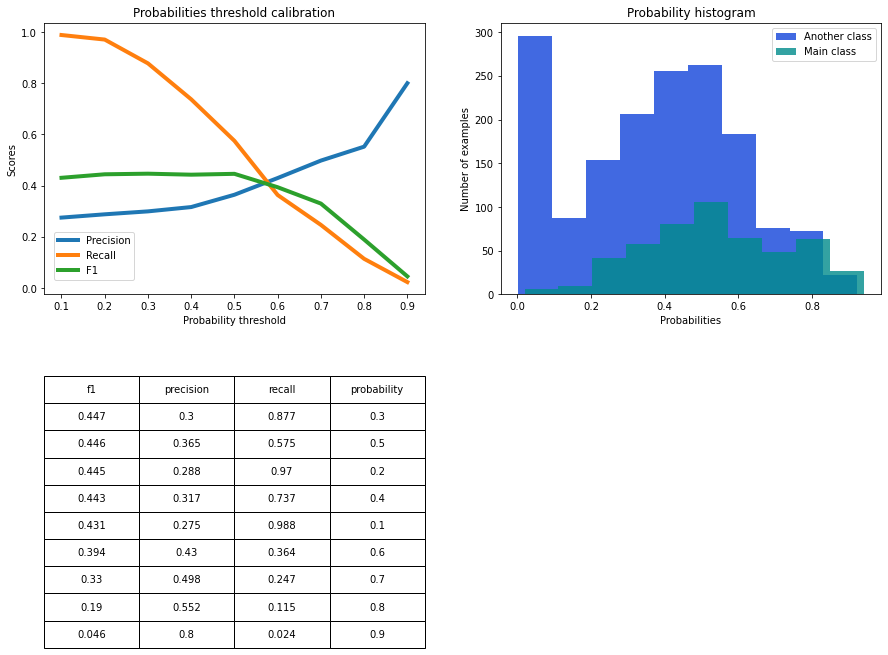

In [129]:
show_proba_calibration_plots(y_test_reduced_pred_probs[:, 1], y_test_reduced)

# -------------------------

In [130]:
df_for_balancing = pd.concat([X_train_reduced, y_train_reduced], axis=1)
TARGET_NAME = 'Credit Default'

df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='over')
    
df_balanced[TARGET_NAME].value_counts()

0    3771
1    3621
Name: Credit Default, dtype: int64

In [131]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

In [132]:
X_train_balanced.dtypes

Credit Score                                     float64
G_home_ownership_home_mortgage                     int64
G_home_ownership_rent                              int64
G_home_ownership_own_home                          int64
G_home_ownership_have_mortgage                     int64
G_home_ownership_other                             int64
G_home_ownership_reduced_to_binary                 int64
G_years_in_current_job_reduced_to_binary           int64
G_purpose_reduced_to_binary                        int64
G_term_transformed_to_binary                       int64
G_tax_liens_reduced_to_binary                      int64
G_number_of_credit_problems_reduced_to_binary      int64
G_bankruptcies_reduced_to_binary                   int64
G_annual_income_target_encoded                   float64
G_current_loan_amount_target_encoded             float64
G_maximum_open_credit_target_encoded             float64
G_number_of_open_accounts_target_encoded         float64
G_years_of_credit_history_targe

In [133]:
from catboost import CatBoostClassifier

In [134]:
disbalance = y_train_balanced.value_counts()[0] / y_train_balanced.value_counts()[1]
disbalance

1.0414250207125104

In [135]:
# model = xgb.XGBClassifier(random_state=21, 
#                           n_estimators=20
#                           )

# model.fit(X_train_balanced, y_train_balanced)

# y_train_pred_reduced = model.predict_proba(X_train_reduced)
# y_test_pred_reduced = model.predict_proba(X_test_reduced)

In [136]:
# model = lgbm.LGBMClassifier(random_state=21, 
# #                             class_weight={0:1, 1:2.54},
#                             n_estimators=5
#                            )

# model.fit(X_train_balanced, y_train_balanced)

# y_train_pred_reduced = model.predict_proba(X_train_reduced)
# y_test_pred_reduced = model.predict_proba(X_test_reduced)

In [137]:
scaler = StandardScaler()

X_train_balanced_norm = X_train_balanced.copy()
X_train_reduced_norm = X_train_reduced.copy()
X_test_reduced_norm = X_test_reduced.copy()

X_train_balanced_norm = scaler.fit_transform(X_train_balanced_norm)
X_train_reduced_norm = scaler.transform(X_train_reduced_norm)
X_test_reduced_norm = scaler.transform(X_test_reduced_norm)

model = LogisticRegression(random_state=21,
                           class_weight={0:1, 1:disbalance})
model.fit(X_train_balanced_norm, y_train_balanced)

y_train_pred_reduced = model.predict_proba(X_train_reduced_norm)
y_test_pred_reduced = model.predict_proba(X_test_reduced_norm)

In [138]:
# model = DecisionTreeClassifier(random_state=21,
# #                                     class_weight={0:1, 1:2.55},
#                                     max_depth=3
#                                     )

# model.fit(X_train_balanced, y_train_balanced)

# y_train_pred_reduced = model.predict_proba(X_train_reduced)
# y_test_pred_reduced = model.predict_proba(X_test_reduced)

In [139]:
# X_train_balanced.dtypes

In [140]:
# model = catb.CatBoostClassifier(silent=True, 
#                                 random_state=21,
#                                 class_weights=[1, disbalance],
#                                 eval_metric='F1',
# #                                 cat_features=CAT_FEATURE_NAMES,
# #                                 one_hot_max_size=10,
#                                 early_stopping_rounds=100,
#                                 use_best_model=True,
#                                 custom_metric=['Precision', 'Recall']
#                                 )

# model.fit(X_train_balanced, y_train_balanced, plot=True, eval_set=(X_test_reduced, y_test_reduced))

# y_train_pred_reduced = model.predict_proba(X_train_reduced)
# y_test_pred_reduced = model.predict_proba(X_test_reduced)

In [141]:
# y_train_pred_reduced = model.predict(X_train_reduced)
# y_test_pred_reduced = model.predict(X_test_reduced)

In [142]:
def classify_results_by_probability(array_of_results_in_probability, probability_threshold):
    list_of_results_in_1_and_0 = []
    for i in array_of_results_in_probability:
        if i[1] <= probability_threshold:
            list_of_results_in_1_and_0.append(0)
        elif i[1] > probability_threshold:
            list_of_results_in_1_and_0.append(1)
    return list_of_results_in_1_and_0    

In [143]:
probability_threshold = 0.603

y_train_pred_reduced = classify_results_by_probability(array_of_results_in_probability=y_train_pred_reduced,
                                                       probability_threshold=probability_threshold)

y_test_pred_reduced = classify_results_by_probability(array_of_results_in_probability=y_test_pred_reduced,
                                                      probability_threshold=probability_threshold)

#### classification_report до присоединения однозначно классифицированных объектов

In [144]:
get_classification_report(y_train_reduced, np.array(y_train_pred_reduced), y_test_reduced, np.array(y_test_pred_reduced))

TRAIN

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      3771
           1       0.44      0.45      0.45      1207

    accuracy                           0.73      4978
   macro avg       0.63      0.64      0.63      4978
weighted avg       0.73      0.73      0.73      4978

TEST

              precision    recall  f1-score   support

           0       0.83      0.80      0.82      1616
           1       0.43      0.47      0.45       506

    accuracy                           0.72      2122
   macro avg       0.63      0.64      0.63      2122
weighted avg       0.73      0.72      0.73      2122

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1300  316
1                270  236


#### присоединение однозначно классифицированных объектов и финальный classification_report

In [145]:
y_train_pred = y_train.copy()
y_test_pred = y_test.copy()

In [146]:
y_train_pred.loc[y_train_reduced.index] = y_train_pred_reduced
y_train_pred.loc[indexes_of_X_train_with_target_0] = 0
y_train_pred.loc[indexes_of_X_train_with_target_1] = 1

y_test_pred.loc[y_test_reduced.index] = y_test_pred_reduced
y_test_pred.loc[indexes_of_X_test_with_target_0] = 0
y_test_pred.loc[indexes_of_X_test_with_target_1] = 1

y_train_pred = np.array(y_train_pred)
y_test_pred = np.array(y_test_pred)

In [147]:
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      3771
           1       0.54      0.55      0.55      1479

    accuracy                           0.74      5250
   macro avg       0.68      0.69      0.68      5250
weighted avg       0.75      0.74      0.74      5250

TEST

              precision    recall  f1-score   support

           0       0.83      0.80      0.82      1616
           1       0.54      0.57      0.55       634

    accuracy                           0.74      2250
   macro avg       0.68      0.69      0.69      2250
weighted avg       0.75      0.74      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1300  316
1                270  364
